# Begining of Life

The purpose of this notebook is to establish basic beginning of life parameters of this concept including $k_{eff}$ and neutron energy spectrum.

In [1]:
import openmc
import openmc.deplete
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np

In [2]:
fuel = openmc.Material(name="uo2")
fuel.add_element("U", 1, percent_type="ao", enrichment=15.5)
fuel.add_element("O", 2)
fuel.set_density("g/cc", 10.5)

clad = openmc.Material(name='clad');
clad.add_element("Zr",1);
clad.set_density('g/cc',6.0);

water = openmc.Material(name='water');
water.add_element('O',1);
water.add_element('H',2)
water.set_density('g/cc',0.712); # high temperature density
water.add_s_alpha_beta('c_H_in_H2O');

materials = openmc.Materials([fuel,clad,water]);

/home/sblair/miniconda3/envs/openmc-env/lib/python3.9/site-packages/openmc/material.py:566: UserWarning: A uranium enrichment of 15.5 was given for Material ID="1". OpenMC assumes the U234/U235 mass ratio is constant at 0.008, which is only valid at low enrichments. Consider setting the isotopic composition manually for enrichments over 5%.
  warnings.warn(msg)


## Pin Cell Geometry

The goal is to establish a pin-cell to provide a simplified representation of the basic criticality and (especially) neutron energy spectrum for this concept.  

In [3]:
h_core = 300.; 
h_fuel = 200.;

r_fuel = 0.42;
r_pin = 0.45;

P_D = 1.15;

pitch = P_D*(2*r_pin);

fuel_temp = 900; # K, representative fuel temperature
mod_temp = 600; # K, representative moderator temperature

# fuel cylinder:
fuel_cyl = openmc.model.RightCircularCylinder([0.,0.,-h_fuel/2.],
                                             h_fuel, r_fuel);

fuel.volume = np.pi*(r_fuel**2)*h_fuel;

# pin cylinder
pin_cyl = openmc.model.RightCircularCylinder([0.,0.,-(h_fuel+(r_pin-r_fuel))/2.],
                                            h_fuel+(r_pin-r_fuel)*2.,r_pin);

# pin cell container
core_cell = openmc.model.RectangularParallelepiped(-pitch/2.,pitch/2.,
                                                  -pitch/2.,pitch/2.,
                                                  -h_core/2.,h_core/2.,
                                                  boundary_type='reflective');

fuel_cell = openmc.Cell();
fuel_cell.region = -fuel_cyl
fuel_cell.fill = fuel;
fuel_cell.temperature = fuel_temp;


clad_cell = openmc.Cell();
clad_cell.region = +fuel_cyl & -pin_cyl;
clad_cell.fill = clad;

mod_cell = openmc.Cell();
mod_cell.region = +pin_cyl & -core_cell;
mod_cell.fill = water

root_univ = openmc.Universe();
root_univ.add_cells([fuel_cell,clad_cell,mod_cell]);

geometry = openmc.Geometry();
geometry.root_universe = root_univ;



materials.export_to_xml();
geometry.export_to_xml();



In [4]:
settings = openmc.Settings();
settings.run_mode = 'eigenvalue';
settings.particles = 20000;
settings.batches = 200;
settings.inactive = 50

box = openmc.stats.Box(lower_left = (-r_fuel,-r_fuel,-h_fuel/2.),
                      upper_right = (r_fuel,r_fuel,h_fuel/2.),
                      only_fissionable=True);
src = openmc.Source(space=box);

settings.source = src;

settings.temperature['method']='interpolation';

settings.export_to_xml();

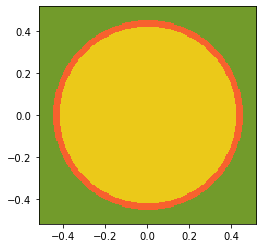

In [5]:
root_univ.plot(width=(pitch,pitch));

In [6]:
# get flux energy spectrum in the fuel

# filter for the fuel cell
cell_filter = openmc.CellFilter(fuel_cell)

# set up energy bins
N = 1001
energy_bins = np.logspace(-3,7,num=N)
energy_filter = openmc.EnergyFilter(values=energy_bins)

# establish flux tally
flux = openmc.Tally(name='flux')
flux.scores = ['flux']
flux.filters = [cell_filter,energy_filter]

tallies = openmc.Tallies([flux])

tallies.export_to_xml()

In [7]:
operator = openmc.deplete.Operator(geometry,settings,"chain_endfb71_pwr.xml")
power = 1e4;
days = 24*3600;
time_steps = [0.1*days, 0.1*days,0.3*days,0.5*days,1.*days,30.*days,30.*days,100.*days,365.*days,365.*days,365.*days,730.*days,730.*days]
integrator = openmc.deplete.PredictorIntegrator(operator,time_steps,power=power);

integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading Mg24 from /home/sblair/OMC_DATA/endfb71_hdf5/Mg24.h5
 Reading Mg25 from /home/sblair/OMC_DATA/endfb71_hdf5/Mg25.h5
 Reading Mg26 from /home/sblair/OMC_DATA/endfb71_hdf5/Mg26.h5
 Reading Al27 from /home/sblair/OMC_DATA/endfb71_hdf5/Al27.h5
 Reading Si28 from /home/sblair/OMC_DATA/endfb71_hdf5/Si28.h5
 Reading Si29 from /home/sblair/OMC_DATA/endfb71_hdf5/Si29.h5
 Reading Si30 from /home/sblair/OMC_DATA/endfb71_hdf5/Si30.h5
 Reading P31 from /home/sblair/OMC_DATA/endfb71_hdf5/P31.h5
 Reading S32 from /home/sblair/OMC_DATA/endfb71_hdf5/S32.h5
 Reading S33 from /home/sblair/OMC_DATA/endfb71_hdf5/S33.h5
 Reading S34 from /home/sblair/OMC_DATA/endfb71_hdf5/S34.h5
 Reading S36 from /home/sblair/OMC_DATA/endfb71_hdf5/S36.h5
 Reading Cl35 from /home/sblair/OMC_DATA/endfb71_hdf5/Cl35.h5
 Reading Cl37 from /home/sblair/OMC_DATA/endfb71_hdf5/Cl37.h5
 Reading Ar36 from /home/sblair/OMC_DATA/endfb71_hdf5/Ar36.h5


 Reading Ar38 from /home/sblair/OMC_DATA/endfb71_hdf5/Ar38.h5
 Reading Ar40 from /home/sblair/OMC_DATA/endfb71_hdf5/Ar40.h5
 Reading K39 from /home/sblair/OMC_DATA/endfb71_hdf5/K39.h5
 Reading K40 from /home/sblair/OMC_DATA/endfb71_hdf5/K40.h5
 Reading K41 from /home/sblair/OMC_DATA/endfb71_hdf5/K41.h5
 Reading Ca40 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca40.h5
 Reading Ca42 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca42.h5
 Reading Ca43 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca43.h5
 Reading Ca44 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca44.h5
 Reading Ca46 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca46.h5
 Reading Ca48 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca48.h5
 Reading Sc45 from /home/sblair/OMC_DATA/endfb71_hdf5/Sc45.h5
 Reading Ti46 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti46.h5
 Reading Ti47 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti47.h5
 Reading Ti48 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti48.h5
 Reading Ti49 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti49.h5
 Reading Ti50 

 Reading Se82 from /home/sblair/OMC_DATA/endfb71_hdf5/Se82.h5
 Reading Br79 from /home/sblair/OMC_DATA/endfb71_hdf5/Br79.h5
 Reading Br81 from /home/sblair/OMC_DATA/endfb71_hdf5/Br81.h5
 Reading Kr78 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr78.h5
 Reading Kr80 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr80.h5
 Reading Kr82 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr82.h5
 Reading Kr83 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr83.h5
 Reading Kr84 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr84.h5
 Reading Kr85 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr85.h5
 Reading Kr86 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr86.h5
 Reading Rb85 from /home/sblair/OMC_DATA/endfb71_hdf5/Rb85.h5
 Reading Rb86 from /home/sblair/OMC_DATA/endfb71_hdf5/Rb86.h5
 Reading Rb87 from /home/sblair/OMC_DATA/endfb71_hdf5/Rb87.h5
 Reading Sr84 from /home/sblair/OMC_DATA/endfb71_hdf5/Sr84.h5
 Reading Sr86 from /home/sblair/OMC_DATA/endfb71_hdf5/Sr86.h5
 Reading Sr87 from /home/sblair/OMC_DATA/endfb71_hdf5/Sr87.h5
 Reading

 Reading Mo92 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo92.h5
 Reading Mo94 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo94.h5
 Reading Mo95 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo95.h5
 Reading Mo96 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo96.h5
 Reading Mo97 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo97.h5
 Reading Mo98 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo98.h5
 Reading Mo99 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo99.h5
 Reading Mo100 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo100.h5
 Reading Tc99 from /home/sblair/OMC_DATA/endfb71_hdf5/Tc99.h5


 Reading Ru96 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru96.h5
 Reading Ru98 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru98.h5
 Reading Ru99 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru99.h5
 Reading Ru100 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru100.h5
 Reading Ru101 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru101.h5
 Reading Ru102 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru102.h5
 Reading Ru103 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru103.h5
 Reading Ru104 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru104.h5
 Reading Ru105 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru105.h5
 Reading Ru106 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru106.h5
 Reading Rh103 from /home/sblair/OMC_DATA/endfb71_hdf5/Rh103.h5
 Reading Rh105 from /home/sblair/OMC_DATA/endfb71_hdf5/Rh105.h5
 Reading Pd102 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd102.h5
 Reading Pd104 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd104.h5
 Reading Pd105 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd105.h5
 Reading Pd106 from /home/sblair/OMC_DATA/endf

          1200K
          2500K


 Reading Cd112 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd112.h5
 Reading Cd113 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd113.h5
 Reading Cd114 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd114.h5
 Reading Cd115_m1 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd115_m1.h5
 Reading Cd116 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd116.h5
 Reading In113 from /home/sblair/OMC_DATA/endfb71_hdf5/In113.h5
 Reading In115 from /home/sblair/OMC_DATA/endfb71_hdf5/In115.h5
 Reading Sn112 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn112.h5
 Reading Sn113 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn113.h5
 Reading Sn114 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn114.h5
 Reading Sn115 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn115.h5
 Reading Sn116 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn116.h5
 Reading Sn117 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn117.h5
 Reading Sn118 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn118.h5
 Reading Sn119 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn119.h5
 Reading Sn120 from /home/sblair/O

          1200K
          2500K


 Reading Sb121 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb121.h5
 Reading Sb123 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb123.h5
 Reading Sb124 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb124.h5
 Reading Sb125 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb125.h5
 Reading Sb126 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb126.h5
 Reading Te120 from /home/sblair/OMC_DATA/endfb71_hdf5/Te120.h5


          1200K
          2500K


 Reading Te122 from /home/sblair/OMC_DATA/endfb71_hdf5/Te122.h5
 Reading Te123 from /home/sblair/OMC_DATA/endfb71_hdf5/Te123.h5
 Reading Te124 from /home/sblair/OMC_DATA/endfb71_hdf5/Te124.h5
 Reading Te125 from /home/sblair/OMC_DATA/endfb71_hdf5/Te125.h5
 Reading Te126 from /home/sblair/OMC_DATA/endfb71_hdf5/Te126.h5
 Reading Te127_m1 from /home/sblair/OMC_DATA/endfb71_hdf5/Te127_m1.h5
 Reading Te128 from /home/sblair/OMC_DATA/endfb71_hdf5/Te128.h5
 Reading Te129_m1 from /home/sblair/OMC_DATA/endfb71_hdf5/Te129_m1.h5
 Reading Te130 from /home/sblair/OMC_DATA/endfb71_hdf5/Te130.h5
 Reading Te132 from /home/sblair/OMC_DATA/endfb71_hdf5/Te132.h5
 Reading I127 from /home/sblair/OMC_DATA/endfb71_hdf5/I127.h5
 Reading I129 from /home/sblair/OMC_DATA/endfb71_hdf5/I129.h5
 Reading I130 from /home/sblair/OMC_DATA/endfb71_hdf5/I130.h5
 Reading I131 from /home/sblair/OMC_DATA/endfb71_hdf5/I131.h5
 Reading I135 from /home/sblair/OMC_DATA/endfb71_hdf5/I135.h5
 Reading Xe123 from /home/sblair/OMC_D

 Reading Xe124 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe124.h5
 Reading Xe126 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe126.h5
 Reading Xe128 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe128.h5
 Reading Xe129 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe129.h5
 Reading Xe130 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe130.h5
 Reading Xe131 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe131.h5
 Reading Xe132 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe132.h5
 Reading Xe133 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe133.h5
 Reading Xe134 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe134.h5
 Reading Xe135 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe135.h5
 Reading Xe136 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe136.h5
 Reading Cs133 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs133.h5


          2500K


 Reading Cs134 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs134.h5
 Reading Cs135 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs135.h5
 Reading Cs136 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs136.h5
 Reading Cs137 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs137.h5
 Reading Ba130 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba130.h5
 Reading Ba132 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba132.h5
 Reading Ba133 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba133.h5


          1200K
          2500K


 Reading Ba134 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba134.h5
 Reading Ba135 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba135.h5
 Reading Ba136 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba136.h5
 Reading Ba137 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba137.h5
 Reading Ba138 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba138.h5
 Reading Ba140 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba140.h5
 Reading La138 from /home/sblair/OMC_DATA/endfb71_hdf5/La138.h5
 Reading La139 from /home/sblair/OMC_DATA/endfb71_hdf5/La139.h5
 Reading La140 from /home/sblair/OMC_DATA/endfb71_hdf5/La140.h5
 Reading Ce136 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce136.h5
 Reading Ce138 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce138.h5
 Reading Ce139 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce139.h5
 Reading Ce140 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce140.h5
 Reading Ce141 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce141.h5
 Reading Ce142 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce142.h5
 Reading Ce143 from /home/sblair/OMC_DAT

          1200K
          2500K


 Reading Gd152 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd152.h5
 Reading Gd153 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd153.h5
 Reading Gd154 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd154.h5
 Reading Gd155 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd155.h5
 Reading Gd156 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd156.h5
 Reading Gd157 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd157.h5
 Reading Gd158 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd158.h5
 Reading Gd160 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd160.h5
 Reading Tb159 from /home/sblair/OMC_DATA/endfb71_hdf5/Tb159.h5
 Reading Tb160 from /home/sblair/OMC_DATA/endfb71_hdf5/Tb160.h5
 Reading Dy156 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy156.h5
 Reading Dy158 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy158.h5
 Reading Dy160 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy160.h5
 Reading Dy161 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy161.h5
 Reading Dy162 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy162.h5
 Reading Dy163 from /home/sblair/OMC_DAT

          1200K


 Reading Cf251 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf251.h5
 Reading Cf252 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf252.h5
 Reading Cf253 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf253.h5
 Reading Cf254 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf254.h5
 Reading Es251 from /home/sblair/OMC_DATA/endfb71_hdf5/Es251.h5
 Reading Es252 from /home/sblair/OMC_DATA/endfb71_hdf5/Es252.h5
 Reading Es253 from /home/sblair/OMC_DATA/endfb71_hdf5/Es253.h5
 Reading Es254 from /home/sblair/OMC_DATA/endfb71_hdf5/Es254.h5
 Reading Es254_m1 from /home/sblair/OMC_DATA/endfb71_hdf5/Es254_m1.h5
 Reading Es255 from /home/sblair/OMC_DATA/endfb71_hdf5/Es255.h5
 Reading Fm255 from /home/sblair/OMC_DATA/endfb71_hdf5/Fm255.h5
 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.35369
        2/1    1.36336
        3/1    1.37946
        4/1    1.37121
        5/1    1.38623
        6/1    1.36418
        7/1    1.37853
        8/1    1.36797
        9/1    1.36391
       10/1    1.37394
       11/1    1.38033
       12/1    1.37910
       13/1    1.38776
       14/1    1.39205
       15/1    1.39285
       16/1    1.38249
       17/1    1.37005
       18/1    1.38506
       19/1    1.39389
       20/1    1.37455
       21/1    1.37650
       22/1    1.38081
       23/1    1.37059
       24/1    1.35682
       25/1    1.37999
       26/1    1.37027
       27/1    1.39080
       28/1    1.36229
       29/1    1.40014
       30/1    1.37796
       31/1    1.36278
       32/1    1.40506
       33/1    1.41116
       34/1    1.37995
       35/1    1.38

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.37848
        2/1    1.36158
        3/1    1.36141
        4/1    1.34790
        5/1    1.37920
        6/1    1.36764
        7/1    1.37080
        8/1    1.37719
        9/1    1.38855
       10/1    1.37587
       11/1    1.35738
       12/1    1.36098
       13/1    1.36748
       14/1    1.37758
       15/1    1.37194
       16/1    1.38574
       17/1    1.36593
       18/1    1.40435
       19/1    1.37281
       20/1    1.37380
       21/1    1.38250
       22/1    1.37808
       23/1    1.37720
       24/1    1.38088
       25/1    1.39011
       26/1    1.36581
       27/1    1.38162
       28/1    1.36682
       29/1    1.39614
       30/1    1.37856
       31/1    1.38501
       32/1    1.38629
       33/1    1.36741
       34/1    1.38238
       35/1    1.37

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.35626
        2/1    1.36464
        3/1    1.34989
        4/1    1.36468
        5/1    1.36949
        6/1    1.38083
        7/1    1.36869
        8/1    1.35765
        9/1    1.36175
       10/1    1.37465
       11/1    1.39806
       12/1    1.36156
       13/1    1.38153
       14/1    1.37406
       15/1    1.38425
       16/1    1.37548
       17/1    1.37613
       18/1    1.36976
       19/1    1.35627
       20/1    1.36628
       21/1    1.37640
       22/1    1.37840
       23/1    1.38956
       24/1    1.37700
       25/1    1.38766
       26/1    1.38081
       27/1    1.37231
       28/1    1.37845
       29/1    1.37737
       30/1    1.38872
       31/1    1.39440
       32/1    1.38222
       33/1    1.37045
       34/1    1.36940
       35/1    1.39

 Maximum neutron transport energy: 8100000.0 eV for Be7
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.37092
        2/1    1.37568
        3/1    1.37516
        4/1    1.37632
        5/1    1.35385
        6/1    1.38555
        7/1    1.35832
        8/1    1.40194
        9/1    1.36053
       10/1    1.41117
       11/1    1.38541
       12/1    1.36578
       13/1    1.35604
       14/1    1.36583
       15/1    1.39248
       16/1    1.37052
       17/1    1.37260
       18/1    1.37967
       19/1    1.38820
       20/1    1.37584
       21/1    1.39648
       22/1    1.37463
       23/1    1.38872
       24/1    1.38019
       25/1    1.36810
       26/1    1.36404
       27/1    1.38269
       28/1    1.37128
       29/1    1.36054
       30/1    1.38436
       31/1    1.35347
       32/1    1.37004
       33

      200/1    1.38773    1.37689 +/- 0.00079
 Creating state point statepoint.200.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 8.1682e+02 seconds
   Time in transport only          = 8.1572e+02 seconds
   Time in inactive batches        = 1.4376e+02 seconds
   Time in active batches          = 6.7306e+02 seconds
   Time synchronizing fission bank = 5.2788e-01 seconds
     Sampling source sites         = 4.7819e-01 seconds
     SEND/RECV source sites        = 4.8640e-02 seconds
   Time accumulating tallies       = 2.8644e-01 seconds
   Time writing statepoints        = 1.4906e-02 seconds
 Total time for finalization       = 2.3410e-03 seconds
 Total time elapsed                = 8.1729e+02 seconds
 Calculation Rate (inactive)       = 6956.08 particles/second
 Calculation Rate (active)         = 4457.

 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.36609
        2/1    1.34795
        3/1    1.37437
        4/1    1.35703
        5/1    1.37464
        6/1    1.38524
        7/1    1.37080
        8/1    1.37451
        9/1    1.37912
       10/1    1.35671
       11/1    1.36601
       12/1    1.37712
       13/1    1.40285
       14/1    1.38149
       15/1    1.37057
       16/1    1.34783
       17/1    1.36937
       18/1    1.36451
       19/1    1.35962
       20/1    1.38971
       21/1    1.36584
       22/1    1.38718
       23/1    1.35894
       24/1    1.38331
       25/1    1.38361
       26/1    1.39876
       27/1    1.36997
       28/1    1.39622
       29/1    1.40128
       30/1    1.38838
       31/1    1.37402
       32/1    1.37372
       33/1    1.38301
       34/1    1.37893
       35/1    1.36

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.35873
        2/1    1.35258
        3/1    1.36141
        4/1    1.35552
        5/1    1.36015
        6/1    1.38003
        7/1    1.38853
        8/1    1.38440
        9/1    1.35868
       10/1    1.38708
       11/1    1.37942
       12/1    1.35821
       13/1    1.36616
       14/1    1.37470
       15/1    1.37653
       16/1    1.36347
       17/1    1.38287
       18/1    1.36639
       19/1    1.38455
       20/1    1.36157
       21/1    1.36962
       22/1    1.38951
       23/1    1.36571
       24/1    1.34032
       25/1    1.38826
       26/1    1.37471
       27/1    1.35954
       28/1    1.36832
       29/1    1.37367
       30/1    1.37183
       31/1    1.37971
       32/1    1.36739
       33/1    1.38473
       34/1    1.39789
       35/1    1.37

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.33058
        2/1    1.34445
        3/1    1.36435
        4/1    1.36226
        5/1    1.36642
        6/1    1.35499
        7/1    1.35723
        8/1    1.38587
        9/1    1.35069
       10/1    1.37945
       11/1    1.36031
       12/1    1.36737
       13/1    1.36992
       14/1    1.37428
       15/1    1.38805
       16/1    1.37249
       17/1    1.36167
       18/1    1.35783
       19/1    1.38584
       20/1    1.37631
       21/1    1.37485
       22/1    1.36543
       23/1    1.37307
       24/1    1.39324
       25/1    1.37238
       26/1    1.38628
       27/1    1.37685
       28/1    1.37774
       29/1    1.37904
       30/1    1.37736
       31/1    1.37484
       32/1    1.36626
       33/1    1.37536
       34/1    1.37978
       35/1    1.37

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.37587
        2/1    1.34732
        3/1    1.35497
        4/1    1.33605
        5/1    1.37095
        6/1    1.34624
        7/1    1.37185
        8/1    1.36272
        9/1    1.38472
       10/1    1.37527
       11/1    1.36269
       12/1    1.36134
       13/1    1.37468
       14/1    1.39587
       15/1    1.36026
       16/1    1.37280
       17/1    1.37945
       18/1    1.37510
       19/1    1.36706
       20/1    1.38902
       21/1    1.37626
       22/1    1.37371
       23/1    1.37096
       24/1    1.37537
       25/1    1.36653
       26/1    1.36756
       27/1    1.35458
       28/1    1.35119
       29/1    1.38434
       30/1    1.37391
       31/1    1.37541
       32/1    1.37710
       33/1    1.36913
       34/1    1.37785
       35/1    1.36

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.33758
        2/1    1.33347
        3/1    1.34229
        4/1    1.32471
        5/1    1.33788
        6/1    1.33877
        7/1    1.35219
        8/1    1.35207
        9/1    1.36855
       10/1    1.35213
       11/1    1.36656
       12/1    1.35559
       13/1    1.36634
       14/1    1.37913
       15/1    1.34870
       16/1    1.37883
       17/1    1.35270
       18/1    1.38090
       19/1    1.36007
       20/1    1.38237
       21/1    1.35658
       22/1    1.36092
       23/1    1.35737
       24/1    1.34995
       25/1    1.34618
       26/1    1.35506
       27/1    1.36520
       28/1    1.35281
       29/1    1.35113
       30/1    1.36056
       31/1    1.39302
       32/1    1.36352
       33/1    1.34675
       34/1    1.36842
       35/1    1.37

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.32016
        2/1    1.31999
        3/1    1.30351
        4/1    1.30671
        5/1    1.34577
        6/1    1.33450
        7/1    1.32248
        8/1    1.32769
        9/1    1.33286
       10/1    1.33185
       11/1    1.34290
       12/1    1.34253
       13/1    1.35457
       14/1    1.35091
       15/1    1.34804
       16/1    1.33387
       17/1    1.34531
       18/1    1.31624
       19/1    1.33673
       20/1    1.34996
       21/1    1.33624
       22/1    1.33757
       23/1    1.31791
       24/1    1.36046
       25/1    1.33031
       26/1    1.33673
       27/1    1.34464
       28/1    1.33008
       29/1    1.33058
       30/1    1.35130
       31/1    1.34304
       32/1    1.32974
       33/1    1.34778
       34/1    1.34063
       35/1    1.35

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.30773
        2/1    1.30827
        3/1    1.31604
        4/1    1.30963
        5/1    1.32524
        6/1    1.30133
        7/1    1.32813
        8/1    1.30577
        9/1    1.31743
       10/1    1.30306
       11/1    1.30483
       12/1    1.32334
       13/1    1.30685
       14/1    1.31631
       15/1    1.30447
       16/1    1.32744
       17/1    1.30755
       18/1    1.31598
       19/1    1.32344
       20/1    1.34940
       21/1    1.31887
       22/1    1.32606
       23/1    1.30458
       24/1    1.32466
       25/1    1.31158
       26/1    1.31696
       27/1    1.32135
       28/1    1.32302
       29/1    1.32061
       30/1    1.33193
       31/1    1.31898
       32/1    1.32977
       33/1    1.31635
       34/1    1.32573
       35/1    1.30

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.29610
        2/1    1.29077
        3/1    1.28208
        4/1    1.29130
        5/1    1.28874
        6/1    1.28682
        7/1    1.30174
        8/1    1.32899
        9/1    1.30521
       10/1    1.29764
       11/1    1.29000
       12/1    1.30435
       13/1    1.32381
       14/1    1.29879
       15/1    1.29808
       16/1    1.30125
       17/1    1.31776
       18/1    1.31105
       19/1    1.29099
       20/1    1.29326
       21/1    1.27751
       22/1    1.29917
       23/1    1.31691
       24/1    1.31864
       25/1    1.29922
       26/1    1.31296
       27/1    1.31373
       28/1    1.30316
       29/1    1.30300
       30/1    1.29416
       31/1    1.29231
       32/1    1.30853
       33/1    1.29491
       34/1    1.29648
       35/1    1.28

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.23891
        2/1    1.25775
        3/1    1.25286
        4/1    1.25272
        5/1    1.25907
        6/1    1.27284
        7/1    1.26699
        8/1    1.25213
        9/1    1.25714
       10/1    1.23882
       11/1    1.26891
       12/1    1.28576
       13/1    1.26070
       14/1    1.24595
       15/1    1.25478
       16/1    1.25417
       17/1    1.26801
       18/1    1.26582
       19/1    1.26547
       20/1    1.27123
       21/1    1.26239
       22/1    1.27523
       23/1    1.25094
       24/1    1.25703
       25/1    1.27502
       26/1    1.25098
       27/1    1.27931
       28/1    1.26424
       29/1    1.25751
       30/1    1.27944
       31/1    1.27273
       32/1    1.26257
       33/1    1.26912
       34/1    1.25845
       35/1    1.26

 Maximum neutron transport energy: 8100000.0 eV for Be7


 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.22717
        2/1    1.22403
        3/1    1.21033
        4/1    1.23827
        5/1    1.21563
        6/1    1.19473
        7/1    1.22336
        8/1    1.21422
        9/1    1.23696
       10/1    1.22565
       11/1    1.21818
       12/1    1.23389
       13/1    1.22315
       14/1    1.22777
       15/1    1.22159
       16/1    1.24091
       17/1    1.22451
       18/1    1.22279
       19/1    1.24225
       20/1    1.23417
       21/1    1.23099
       22/1    1.23877
       23/1    1.23023
       24/1    1.24122
       25/1    1.24138
       26/1    1.23116
       27/1    1.25226
       28/1    1.22224
       29/1    1.23408
       30/1    1.21599
       31/1    1.24713
       32/1    1.21673
       33/1    1.25566
       34/1    1.23646
       35/1    1.24

In [8]:
results = openmc.deplete.ResultsList.from_hdf5('./depletion_results.h5')

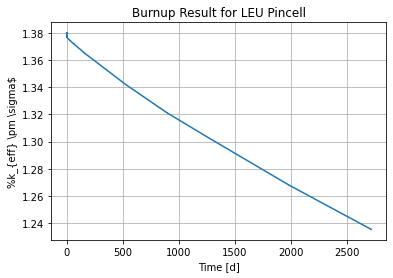

In [10]:
time,k = results.get_eigenvalue()
time /= (24*60*60)

plt.errorbar(time,k[:,0],yerr=k[:,1])
plt.title('Burnup Result for LEU Pincell')
plt.xlabel('Time [d]')
plt.ylabel('%k_{eff} \pm \sigma$')
plt.grid()

Text(0, 0.5, 'Number of atoms Cs137')

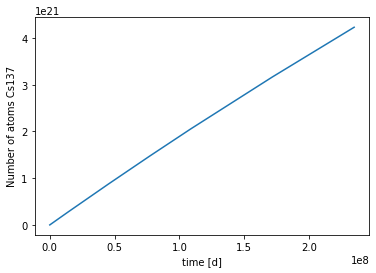

In [14]:
time, cs137 = results.get_atoms("1","Cs137")# I should verify that fuel is material "1"
plt.plot(time,cs137,label="Cs137")
plt.xlabel("time [d]")
plt.ylabel("Number of atoms Cs137")

So....some things do not change significantly.  

Text(0, 0.5, 'Number of atoms Pu239')

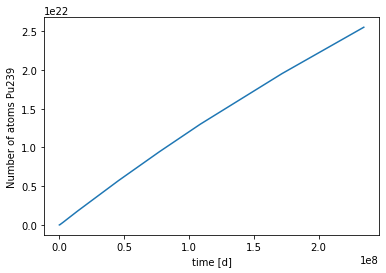

In [12]:
time, Pu239 = results.get_atoms("1","Pu239")
plt.plot(time,Pu239,label="Pu239")
plt.xlabel("time [d]")
plt.ylabel("Number of atoms Pu239")

Some things are different.  More Pu239 created in the HALEU reactor; also the dynamics of Pu239 generation are different.  Let's check out the other Pu isotopes

Text(0, 0.5, 'Number of atoms')

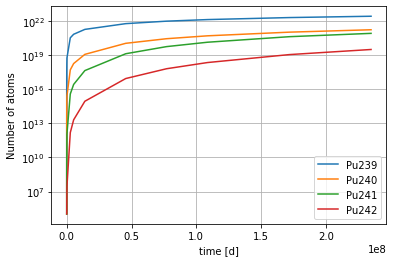

In [17]:
time, Pu240 = results.get_atoms("1","Pu240")
time, Pu241 = results.get_atoms("1","Pu241")
time, Pu242 = results.get_atoms("1","Pu242")

plt.semilogy(time,Pu239,label="Pu239")
plt.semilogy(time,Pu240,label="Pu240")
plt.semilogy(time,Pu241,label="Pu241")
plt.semilogy(time,Pu242,label="Pu242")
plt.legend()
plt.grid()
plt.xlabel("time [d]")
plt.ylabel("Number of atoms")